<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/Face2Gene_VGG_face_10_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Class and samples
'''

Angelman:     205
Williams:     231
FragileX:     163
CDL:  250
TreacherCollins:      103
Apert:        200
Down: 197
Progeria:     150
Charge: 178
Noonan: 154
BWS: 211

'''

'\n\nAngelman:     205\nWilliams:     231\nFragileX:     163\nCDL:  250\nTreacherCollins:      103\nApert:        200\nDown: 197\nProgeria:     150\nCharge: 178\nNoonan: 154\nBWS: 211\n\n'

In [ ]:
!pip install keras_applications
!pip install keras_vggface
!pip install tensorflow-addons

In [ ]:
!nvidia-smi

Fri Jun 11 06:13:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: aayushktyagi (use `wandb login --relogin` to force relogin)


True

In [ ]:
import numpy as np 
import sys 
import os 
import time 
import cv2 
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [ ]:
# #Tensorflow utilities
# import tensorflow as tf
# import tensorflow_addons as tfa
# from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.models import Model , load_model, Sequential
# from tensorflow.keras.layers import Dense , Input , Flatten , Dropout ,BatchNormalization
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.applications import NASNetLarge
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from keras_vggface.vggface import VGGFace
# from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
#keras
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model , load_model, Sequential
from keras.layers import Dense , Input , Flatten , Dropout ,BatchNormalization
# from keras.applications import ResNet50
# from keras.applications import DenseNet121
# from keras.applications import NASNetLarge
# from keras.applications import Xception
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras_vggface.vggface import VGGFace
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)


In [ ]:
# base data path 
train_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Dataset/Face2Gene_10_split/train'
val_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Dataset/Face2Gene_10_split/val'
test_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Dataset/Face2Gene_10_split/test'

In [ ]:
# loading data

image_size = 224
train_batch_size = 32
val_batch_size = 32
model_name = 'VGG_Face'  # ResNet50/DenseNet

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   rotation_range = 10,
                                  #  width_shift_range = 0.10,
                                  #  height_shift_range = 0.1,
                                  #  zoom_range=0.10, 
                                   horizontal_flip = True
                                  )

valid_datagen = ImageDataGenerator(rescale = 1/255.)

test_datagen = ImageDataGenerator(rescale = 1/255.)


train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size= train_batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = valid_datagen.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size= val_batch_size,
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
            test_path,
            target_size = (image_size, image_size),
            batch_size = 1,
            class_mode = 'categorical',
            shuffle = False)


train_num_classes = len(train_generator.class_indices)
val_num_classes = len(validation_generator.class_indices)
test_num_classes = len(test_generator.class_indices)

Found 1499 images belonging to 10 classes.
Found 185 images belonging to 10 classes.
Found 194 images belonging to 10 classes.


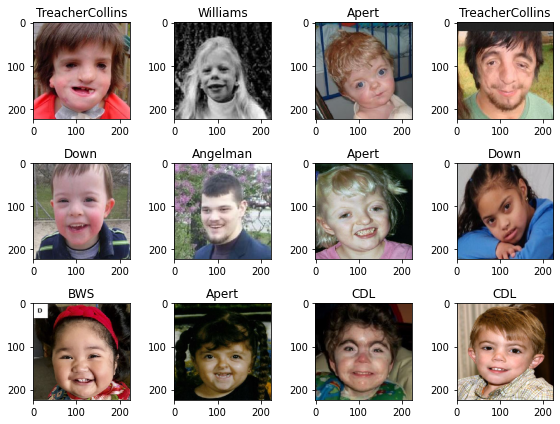

In [ ]:
# Visualize images

def display_images_sample(images, labels, class_list ,columns=4,rows=3):
    fig = plt.figure(figsize=(2*columns,2*rows))

    for i in range(columns*rows):
        fig.add_subplot(rows,columns,i+1)
        img = images[i]
        image_id = np.argmax(labels[i])
        class_label = class_list[image_id]
        plt.title(class_label)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

class_list = list(train_generator.class_indices.keys())
images , labels = next(validation_generator)
display_images_sample(images, labels, class_list)

In [ ]:
# Load model 

if model_name == 'ResNet50':
  img = Input(shape=(image_size,image_size,3))
  base_model = ResNet50(include_top = False,
                          weights= 'imagenet',
                          input_tensor=img,
                          pooling='avg',
                          input_shape = None)

  final_layer = base_model.layers[-1].output
  final_layer = Dropout(0.2)(final_layer)
  dense_layer1 = Dense(512, activation='relu')(final_layer)
  dense_layer1 = Dropout(0.2)(dense_layer1)
  # dense_layer1 = BatchNormalization()(dense_layer1)
  dense_layer2 = Dense(256,activation= 'relu')(dense_layer1)
  dense_layer2 = Dropout(0.2)(dense_layer2)
  dense_layer3 = Dense(128,activation= 'relu')(dense_layer2)
  output_layer = Dense(train_num_classes,activation='softmax')(dense_layer3)

  model = Model(img,output_layer)
  for layer in base_model.layers:
      layer.trainable = False
      
  model.summary()

In [ ]:
if model_name == 'VGG_Face':
  img = Input(shape=(image_size,image_size,3))
  base_model = VGGFace(model='resnet50', include_top=False, input_shape=None, input_tensor= img)
  
  final_layer = base_model.get_layer('avg_pool').output
  final_layer = Flatten()(final_layer)
  # final_layer = Dropout(0.2)(final_layer)
  dense_layer1 = Dense(512, activation='relu')(final_layer)
  dense_layer1 = BatchNormalization()(dense_layer1)
  dense_layer1 = Dropout(0.2)(dense_layer1)
  dense_layer2 = Dense(256,activation= 'relu')(dense_layer1)
  dense_layer1 = BatchNormalization()(dense_layer1)
  dense_layer2 = Dropout(0.2)(dense_layer2)
  dense_layer3 = Dense(128,activation= 'relu')(dense_layer2)
  dense_layer1 = BatchNormalization()(dense_layer1)
  output_layer = Dense(train_num_classes,activation='softmax')(dense_layer3)

  model = Model(img,output_layer)
  for layer in base_model.layers:
      layer.trainable = True
      
  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [ ]:
if model_name == 'DenseNet':
  img = Input(shape=(image_size,image_size,3))
  base_model = DenseNet121(include_top = False,
                          weights= 'imagenet',
                          input_tensor=img,
                          pooling='avg',
                          input_shape = None)

  final_layer = base_model.layers[-1].output
  final_layer = Dropout(0.2)(final_layer)
  dense_layer1 = Dense(512, activation='relu')(final_layer)
  dense_layer1 = Dropout(0.2)(dense_layer1)
  dense_layer1 = BatchNormalization()(dense_layer1)
  dense_layer2 = Dense(256,activation= 'relu')(dense_layer1)
  dense_layer2 = Dropout(0.2)(dense_layer2)
  dense_layer3 = Dense(128,activation= 'relu')(dense_layer2)
  output_layer = Dense(train_num_classes,activation='softmax')(dense_layer3)

  model = Model(img,output_layer)
  for layer in base_model.layers:
      layer.trainable = False
      
  model.summary()

In [ ]:
callbacks = [
    EarlyStopping(patience=25, verbose=1,monitor='val_loss'),
    ReduceLROnPlateau(factor=0.05, patience=5, min_lr=0.000000001, verbose=1,monitor='val_loss'),
    # ModelCheckpoint('/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Models/VGG_face_ResNet_11_basemodel_sgd_lr01_hf_r10.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
run = wandb.init(project='Face2Gene',
           config={
              "learning_rate": 0.01,
              "Tags":"10_Class",
              "epochs": 200,
              "batch_size": 64,
              "loss_function": "categorical_crossentropy",
              "architecture": "VGG_Face",
              "dataset": "Face2Gene"
           })
config = wandb.config

# compile model like you usually do.
# notice use of config.
optimizer = tf.keras.optimizers.SGD(learning_rate = config.learning_rate)
model.compile(optimizer, config.loss_function, metrics=['categorical_accuracy','Precision','Recall',tfa.metrics.F1Score(num_classes=train_num_classes, average='macro')])

In [ ]:
# # optimizer = tf.keras.optimizers.Adam(lr = 0.001)
# optimizer = tf.keras.optimizers.SGD(lr=1e-2)
# # optimizer = tf.keras.optimizers.Nadam(lr = 0.01)
# model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy','Precision','Recall',tfa.metrics.F1Score(num_classes=train_num_classes, average='macro')])

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=37,
        epochs = config.epochs,
        validation_data = validation_generator,
        validation_steps=5,
        callbacks= [callbacks,WandbCallback(save_model = False)]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
37/37 [==============================] - 409s 10s/step - loss: 2.0862 - categorical_accuracy: 0.3095 - precision: 0.5313 - recall: 0.1291 - f1_score: 0.2067 - val_loss: 2.3452 - val_categorical_accuracy: 0.0875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.4052
Epoch 2/200
37/37 [==============================] - 79s 2s/step - loss: 0.9334 - categorical_accuracy: 0.7028 - precision: 0.8520 - recall: 0.5531 - f1_score: 0.4514 - val_loss: 2.4676 - val_categorical_accuracy: 0.1000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.5369
Epoch 3/200
37/37 [==============================] - 29s 793ms/step - loss: 0.5835 - categorical_accuracy: 0.8086 - precision: 0.8863 - recall: 0.7329 - f1_score: 0.5576 - val_loss: 4.8126 - val_categorical_accuracy: 0.0938 - val_precision: 0.1429 - val_recall: 0.0250 - val_f1_score: 0.6078
Epoch 4/200
37/37 [==============================] - 20s 549ms/step - loss: 0.4851 - categorical_accuracy: 0.846

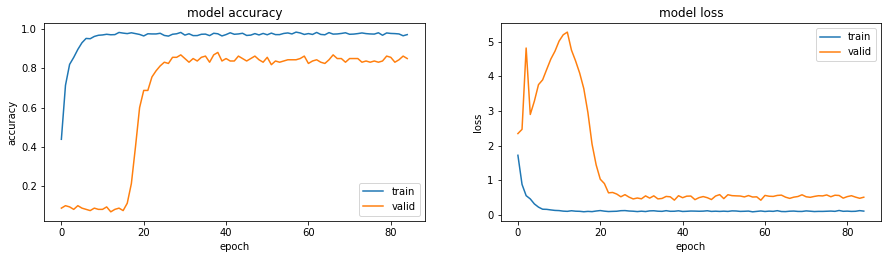

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['categorical_accuracy'])  
plt.plot(fit_history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# Load model 
# model.load_weights('/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Models/VGG_face_ResNet_8_basemodel_sgd_lr01_hf_r5_s10.h5')

In [ ]:
scores = model.evaluate(test_generator,steps= len(test_generator),verbose = 1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

194/194 [==============================] - 60s 309ms/step - loss: 0.4385 - categorical_accuracy: 0.8660 - precision: 0.9045 - recall: 0.8299 - f1_score: 0.9258

categorical_accuracy: 86.60%


In [ ]:
# Add test results to W&B
wandb.log({'Test Accuracy': scores[1]*100})

run.join()

epoch,84
loss,0.10874
categorical_accuracy,0.97201
precision,0.98177
recall,0.95929
f1_score,0.92573
val_loss,0.50969
val_categorical_accuracy,0.85
val_precision,0.86667
val_recall,0.8125
val_f1_score,0.92592


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
categorical_accuracy,▁▆▇█████████████████████████████████████
precision,▁▆▇█████████████████████████████████████
recall,▁▆▇█████████████████████████████████████
f1_score,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
val_loss,▄▇▅▆▇██▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁▁▁▁▁▁▁▁▂▆▆▇████████████▇███████████████
val_precision,▁▂▁▂▂▂▂▂▃▆▇█████████████████████████████
val_recall,▁▁▁▂▂▂▂▂▃▅▆▇▇███████████████████████████
val_f1_score,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████


In [ ]:
pred = model.predict(test_generator, steps = len(test_generator), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)

194/194 [==============================] - 6s 13ms/step


Classification accuracy:0.865979381443299

0.865979381443299
Classification report
              precision    recall  f1-score   support

           0       0.88      0.71      0.79        21
           1       0.94      0.85      0.89        20
           2       0.90      0.86      0.88        21
           3       0.96      1.00      0.98        25
           4       0.94      0.84      0.89        19
           5       0.77      0.95      0.85        21
           6       0.68      0.76      0.72        17
           7       0.93      0.93      0.93        15
           8       0.83      0.91      0.87        11
           9       0.83      0.83      0.83        24

    accuracy                           0.87       194
   macro avg       0.87      0.87      0.86       194
weighted avg       0.87      0.87      0.87       194



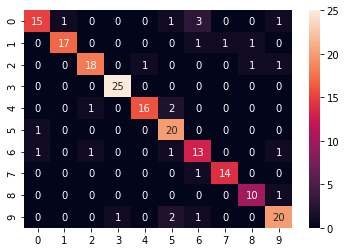

In [ ]:
# class wise 
def predict(test_generator, predicted_class_index):

    confusion_mat_score = confusion_matrix(test_generator,predicted_class_index)
    sns.heatmap(confusion_mat_score, annot=True)
    # sns.heatmap(results/np.sum(results), annot=True, fmt='.2%', cmap='Blues')
    # print(results)
    #Classification accuracy
    accuracy = accuracy_score(test_generator,predicted_class_index)
    print("Classification accuracy:{}".format(accuracy))
    print()
    print(accuracy)
    #Classification report 
    classify_report = classification_report(test_generator,predicted_class_index)
    print("Classification report")
    print(classify_report)

    return confusion_mat_score, accuracy, classify_report
    
confusion_mat_score, accuracy, classification_report = predict(test_generator.classes, predicted_class_indices)

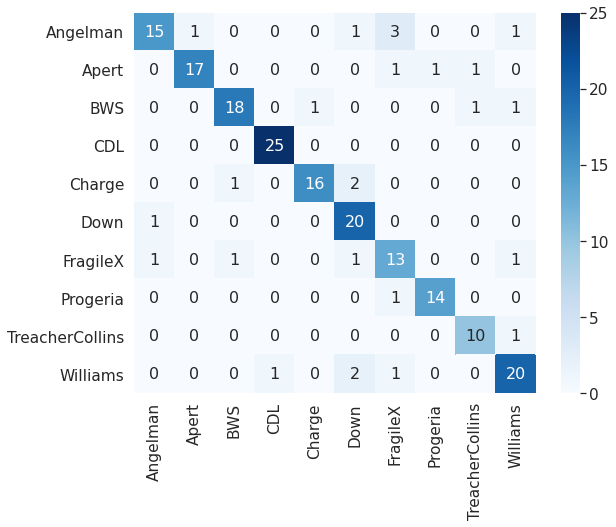

In [ ]:
# Confusion matrix
df_cm = pd.DataFrame(confusion_mat_score, columns=class_list, index = class_list)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (9,7))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

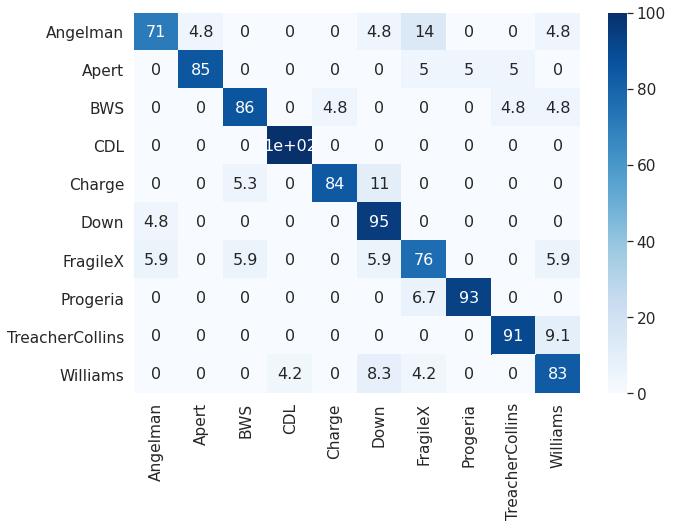

In [ ]:
# Confusion matrix
cm_sum = np.sum(confusion_mat_score,axis=1, keepdims=True)
cm_perc = confusion_mat_score / cm_sum.astype(float) * 100
df_cm = pd.DataFrame(cm_perc, columns=class_list, index = class_list)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

194/194 [==============================] - 3s 13ms/step


0.9253626467089303

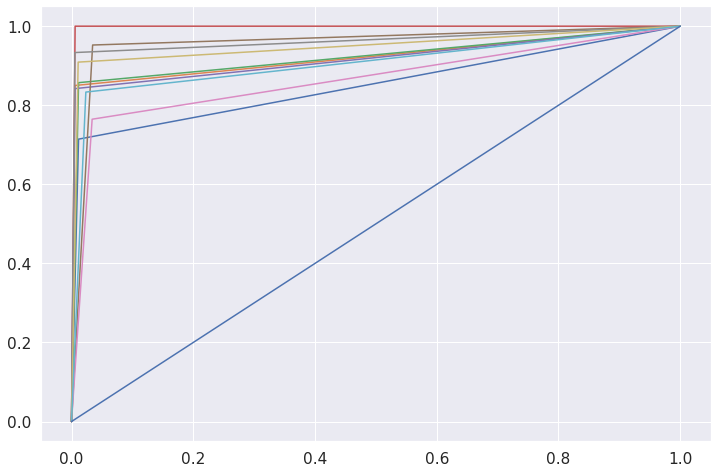

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_list): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
test_generator.reset() # resetting generator
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)